### Loads necessary stuff

In [144]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline


### Defines tuning methods

In [145]:
def getTuningParametersAdaBoost():
    params = {'n_estimators': [10, 20, 50, 100, 200],
                  'learning_rate': [1.0, .5, .25, .15]}
    return params

def getTuningParametersLinReg():
    params = {"loss": ["log", "hinge"], "penalty": ["l2", "l1", "elasticnet"]}
    return params

def getTuningParametersDT():
    params = {'criterion': ('gini', 'entropy'),
              'splitter': ('best', 'random')}
    return params

def getTuningParametersRF():
    params = {'n_estimators': [10, 20, 50, 100, 200],
              'criterion': ('gini', 'entropy')}
    return params

def tuneClassifier(clf, X_train, Y_train):
    clfName = clf.__class__.__name__
    parameters = []
    if type(clf) is AdaBoostClassifier:
        parameters = getTuningParametersAdaBoost()
    if type(clf) is SGDClassifier:
        parameters = getTuningParametersLinReg()
    if type(clf) is DecisionTreeClassifier:
        parameters = getTuningParametersDT()
    if type(clf) is RandomForestClassifier:
        parameters = getTuningParametersRF()
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters,\
                        n_jobs = 4, cv=10)
    grid_obj.fit(X_train, Y_train)
    clf = grid_obj.best_estimator_
    return clf

### Loads the data

In [146]:
### Loads both training and test data
#### DETAIL: THE CLASS IS `Credit-Application-Result`
df_training = pd.read_csv("../training.csv")
df_test = pd.read_csv("../test.csv")
# display(df_training.head())
# display(df_test.head())
# df_complete = pd.concat([df_training, df_test], axis = 0)
# display(df_complete['Credit-Application-Result'])

### Counts the number of values for each categorical attribute

In [147]:
for attribute in df_training.columns.values:
#     if df_training[attribute].dtype == object:
        count = pd.Series.value_counts(df_training[attribute])
        print "{}\n".format(attribute)
        print count
        print "------------------------------"

Account-Balance

No Account      262
Some Balance    238
Name: Account-Balance, dtype: int64
------------------------------
Duration-of-Credit-Month

24    108
12     92
18     45
36     41
6      34
9      27
48     27
15     24
30     18
21     13
10     11
60      8
27      5
8       5
11      5
42      5
4       4
45      4
20      4
28      3
33      3
7       3
39      3
14      2
47      1
26      1
40      1
16      1
22      1
13      1
Name: Duration-of-Credit-Month, dtype: int64
------------------------------
Payment-Status-of-Previous-Credit

Paid Up                       260
No Problems (in this bank)    204
Some Problems                  36
Name: Payment-Status-of-Previous-Credit, dtype: int64
------------------------------
Purpose

Home Related    355
Used car         83
New car          47
Other            15
Name: Purpose, dtype: int64
------------------------------
Credit-Amount

3017     3
1258     3
1154     2
1549     2
701      2
1449     2
1275     2
930      2
7

### from the previous list of values, we see that `Concurrent-Credits` has only one possible value, and that's why it should be removed

In [148]:
df_training.drop('Concurrent-Credits', axis=1, inplace=True)
df_training.drop('Occupation', axis=1, inplace=True)
df_test.drop('Concurrent-Credits', axis=1, inplace=True)
df_test.drop('Occupation', axis=1, inplace=True)

### Data cleansing

In [149]:
numInstances = df_training.shape[0]
numAttributes = df_training.shape[1] - 1 #remove the class
classLabel = 'Credit-Application-Result'
### Removes all attributes with more than 50% of the data missing
toRemove = []
for attribute in df_training.columns.values:
    num_missing_values = df_training[attribute].isnull().sum()
    if num_missing_values / numAttributes > .5 and attribute != classLabel:
        print '\t attribute {} has {} missing values, and thus, will be removed!'.format(attribute, num_missing_values)
        toRemove.append(attribute)

### Convert all string stuff into dummies

for attribute in df_test.columns.values:
    if df_test[attribute].dtype == object and attribute != classLabel:
        dummies_training = pd.get_dummies(df_training[attribute], prefix=[attribute])
        dummies_test     = pd.get_dummies(df_test[attribute], prefix=[attribute])        
        df_training      = pd.concat([df_training, dummies_training], axis = 1)
        df_test          = pd.concat([df_test, dummies_test], axis = 1)        
        toRemove.append(attribute)

toRemove = list(set(toRemove))
print 'Attributes to be removed = {}'.format(toRemove)

for attribute in toRemove:
    df_training.drop(attribute, axis=1, inplace=True)
    df_test.drop(attribute, axis=1, inplace=True)

    
    
    
### Works with imputation to replace missing values
for attribute in df_test.columns.values:
    df_training[attribute].fillna((df_training[attribute].mean()), inplace=True)
    df_test[attribute].fillna((df_test[attribute].mean()), inplace=True)


# display(df_training.head())
# display(df_test.head())
# print df_training.shape
# print df_test.shape
        
# mean = np.mean(df_training['Age-years'])
# print "age-years mean = {0:.2f}".format(mean)


# pd.scatter_matrix(df_training, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

	 attribute Duration-in-Current-address has 344 missing values, and thus, will be removed!
Attributes to be removed = ['Duration-in-Current-address', 'Length-of-current-employment', 'Value-Savings-Stocks', 'Guarantors', 'Account-Balance', 'Purpose', 'Payment-Status-of-Previous-Credit', 'No-of-Credits-at-this-Bank']


### Correlation check

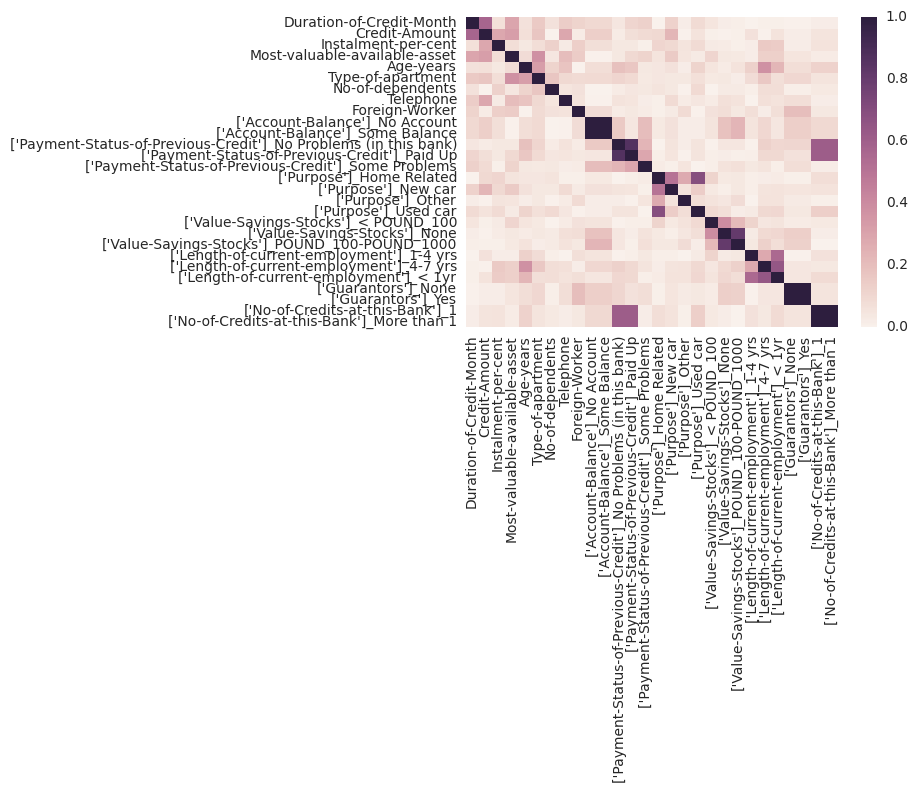

In [150]:
toRemoveCorrelation = []
df_correlation = df_training.drop('Credit-Application-Result', axis = 1)# display(df_training.corr())
df_correlation = df_correlation.corr().abs()

#### PLOTS THIS AS A HEATMAP
import seaborn as sns
sns.heatmap(df_correlation, 
            xticklabels=df_correlation.columns.values,
            yticklabels=df_correlation.columns.values)




In [151]:
## Checks each pair to find which should be removed
for att in df_correlation.columns.values:
    for att2 in df_correlation.columns.values:
        if att != att2:
            value = df_correlation.get_value(att, att2)
            if value > 0.7:
#                 print "correl({}, {}) = {}".format(att, att2, value)
                removeAtt = att
                if att2 < att:
                    removeAtt = att2
                toRemoveCorrelation.append(removeAtt)
toRemoveCorrelation = list(set(toRemoveCorrelation))
print "Highly correlated features to be removed = {}".format(toRemoveCorrelation)

for att in toRemoveCorrelation:
    df_training.drop(att, axis=1, inplace=True)
    df_test.drop(att, axis=1, inplace=True)

Highly correlated features to be removed = ["['Account-Balance']_No Account", "['Guarantors']_None", "['Payment-Status-of-Previous-Credit']_No Problems (in this bank)", "['No-of-Credits-at-this-Bank']_1", "['Value-Savings-Stocks']_None"]


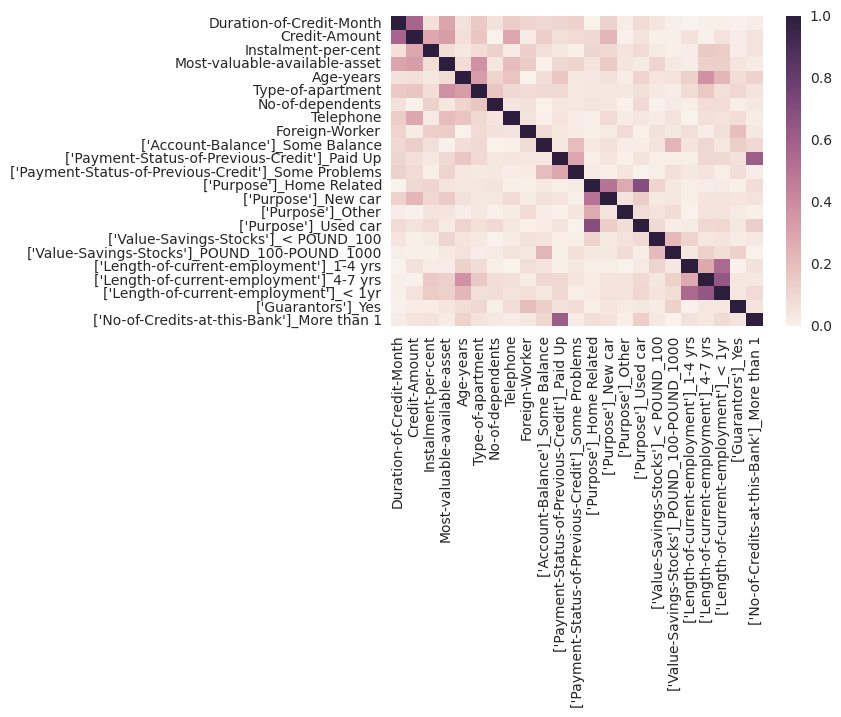

In [152]:
df_correlation = df_training.drop('Credit-Application-Result', axis = 1)
df_correlation = df_correlation.corr().abs()

#### PLOTS THIS AS A HEATMAP
import seaborn as sns
sns.heatmap(df_correlation, 
            xticklabels=df_correlation.columns.values,
            yticklabels=df_correlation.columns.values)

### Splits the data into training and testing sets

In [153]:
### It happens that "['Purpose']_Other" appears in the training set but not in the test, so let's remove it
df_training.drop("['Purpose']_Other", axis = 1, inplace = True)
  
 
### Splits the data into training and testing structures
X_train = df_training.drop(classLabel, axis = 1)
X_test  = df_test
Y_train = df_training[classLabel]


## Just in case:
print X_train.shape
print X_test.shape
print Y_train.shape

(500, 22)
(500, 22)
(500,)


### Trains the classifiers

Tuning DT...
	 DT tuned!
DT had an accuracy of 69.696969697% on the validation score
Importances 
 [ 0.10974074  0.08775414  0.09400675  0.07943348  0.10628252  0.03397792
  0.03278309  0.06119975  0.01475034  0.06067437  0.0298706   0.03359619
  0.01724836  0.0136889   0.02386241  0.02128624  0.04715264  0.
  0.01665582  0.04357561  0.03983509  0.03262503]
Tuning RF...
	 RF tuned!
RF had an accuracy of 79.3939393939% on the validation score
Importances 
 [ 0.127842    0.19322481  0.0617086   0.05915187  0.13302344  0.03483222
  0.02964181  0.03105962  0.00959803  0.05647113  0.02508573  0.03264183
  0.02574118  0.01332507  0.01519697  0.01723104  0.03014291  0.01936389
  0.01663862  0.02603947  0.01638391  0.02565585]
Tuning AdaBoost...
	 AdaBoost tuned!
AdaBoost had an accuracy of 75.1515151515% on the validation score
Importances 
 [ 0.14  0.2   0.04  0.    0.14  0.    0.08  0.    0.    0.08  0.    0.1
  0.04  0.06  0.    0.02  0.02  0.02  0.    0.06  0.    0.  ]
Tuning SGD...
	 SGD

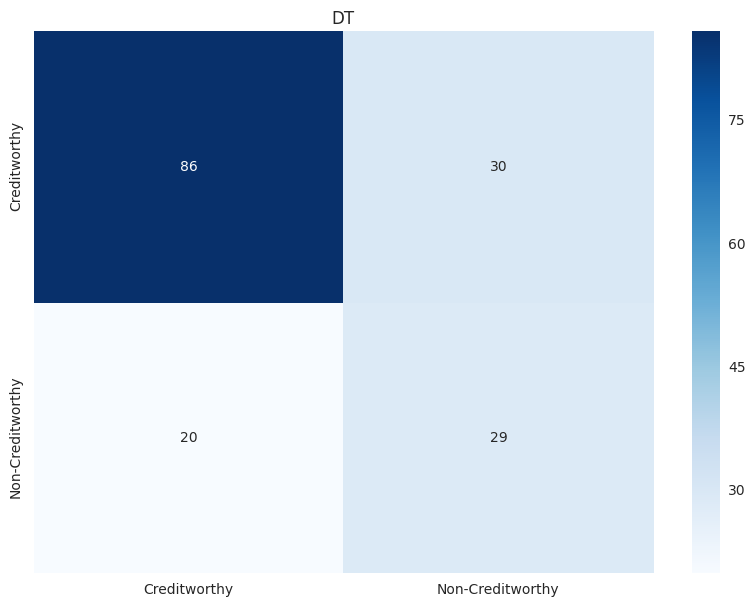

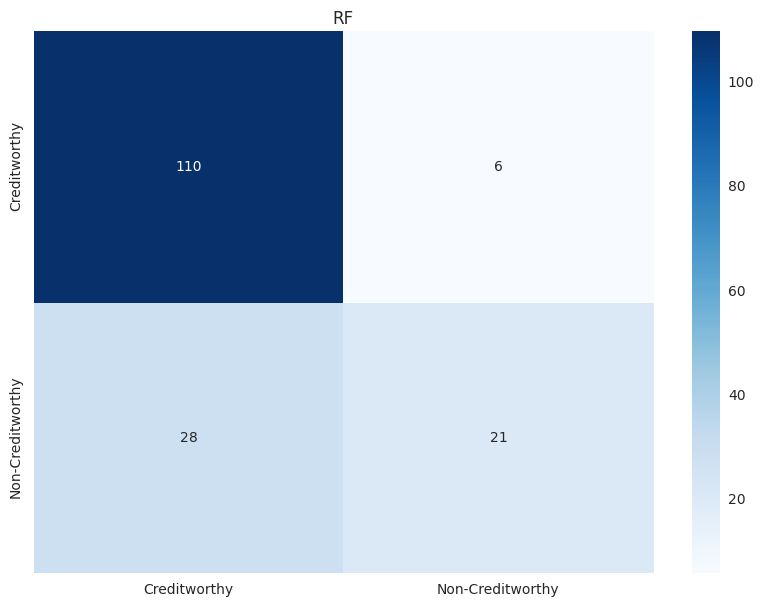

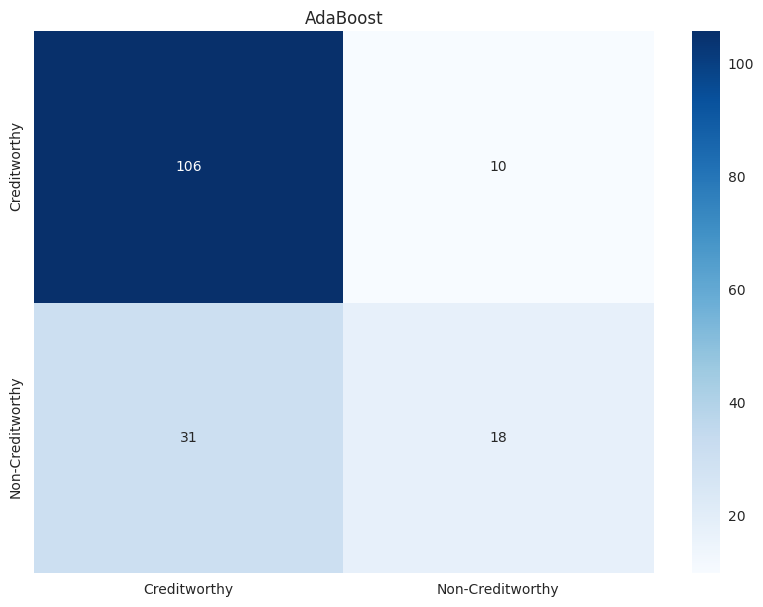

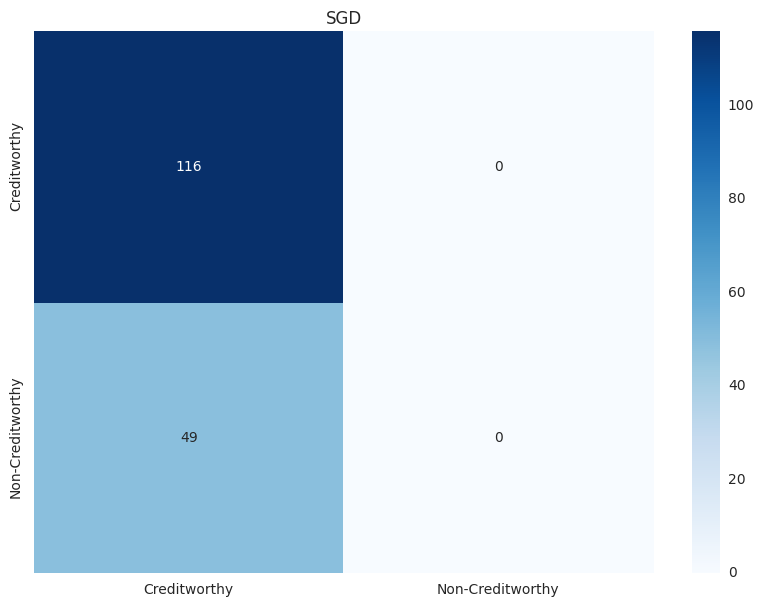

In [154]:
### breaks the train subset into pure training and validation sets
from sklearn.model_selection import train_test_split
pure_X_train, validation_X, pure_Y_train,  validation_Y = train_test_split(X_train, Y_train, test_size=0.33, random_state=1)


### just to be sure
# display(pure_X_train)
# display(pure_Y_train)
# print pure_X_train.shape
# print pure_Y_train.shape
# print validation_X.shape
# print validation_Y.shape    
    
### Trains all classifiers and presents the results on the validation set
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
classifiers = {'AdaBoost' : AdaBoostClassifier(random_state = 1), 'SGD' : SGDClassifier(random_state = 15),
                'DT' : DecisionTreeClassifier(random_state = 1), 'RF' : RandomForestClassifier(random_state = 1)
              }
tunedClassifiers = {}
for classifierName, classifier in classifiers.iteritems():
    print 'Tuning {}...'.format(classifierName)
    tunedClassifier = tuneClassifier(classifier, pure_X_train, pure_Y_train)
    tunedClassifiers[classifierName] = tunedClassifier
    print '\t {} tuned!'.format(classifierName)
    predictions = tunedClassifier.predict(validation_X)
    acc = accuracy_score(validation_Y, predictions)

    print "{} had an accuracy of {}% on the validation score".format(classifierName, 100 * acc)
    importances = []
    if type(classifier) is SGDClassifier:
        importances = tunedClassifier.coef_
    else:
        importances = tunedClassifier.feature_importances_
    print "Importances \n {}".format(importances)
#     print "Confusion Matrix \n"
    confusionMatrix= confusion_matrix(validation_Y, predictions)
    df_cm = pd.DataFrame(confusionMatrix, index = ["Creditworthy", "Non-Creditworthy"],
                  columns = ["Creditworthy", "Non-Creditworthy"])
    plt.figure(figsize = (10,7))
    sns.plt.title(classifierName)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [155]:
### Gets the list of attributes for the table in the report
# print df_training.columns.values

### Applies each of the tuned classifiers to the test set

In [156]:
# print df_test.columns.values
for classifierName, classifier in tunedClassifiers.iteritems():
    if type(classifier) is RandomForestClassifier:
        predictions = classifier.predict(X_test)        
        worthy = np.where(predictions == 'Creditworthy')[0].size
        print 'Worthy = {} and Non-worthy = {}'.format(worthy, X_test.shape[0]-worthy)

Worthy = 431 and Non-worthy = 69
